# Transfer learning with Tensorflow Part 1: Feature Extraction

Trasnsfer learning is leveraging a working model's existing architecture and learned pattern for our own problems

Why are we using it:
1. Can use existing architecture which have been proven to work
2. Can use models which have already learned patterns on similar data

## Downloading and becoming one with the data

# Get 10% of 10 food classes from Food101
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_file = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_file.extractall()
zip_file.close()

In [1]:
# How many images in each folder
import os

# walk through 10% data directory and list number of files

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 10 directori

## Creating data loaders

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
TRAIN_DIR = "10_food_classes_10_percent/train/"
TEST_DIR = "10_food_classes_10_percent/test/"
CLASS_MODE = 'categorical'

train_datagen = ImageDataGenerator(rescale= 1/255.)
test_datagen = ImageDataGenerator(rescale= 1/255.)

print("Loading training images: ")
train_data_10_percent = train_datagen.flow_from_directory(TRAIN_DIR,
                                                          target_size= IMAGE_SHAPE,
                                                          batch_size= BATCH_SIZE,
                                                          class_mode= CLASS_MODE)

print("Loading testing images: ")
test_data = test_datagen.flow_from_directory(TEST_DIR,
                                             target_size= IMAGE_SHAPE,
                                             batch_size= BATCH_SIZE,
                                             class_mode= CLASS_MODE)

Loading training images: 
Found 750 images belonging to 10 classes.
Loading testing images: 
Found 2500 images belonging to 10 classes.


## Setting up callbacks

Callbacks are extra functionality you can add into your models to be performed during or after training. 

Some of the most popular callbacks are:
* Tracking the experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training with the EarlyStopping callback

In [3]:
# Create tensorboard callback (functionized)

import datetime
import tensorflow as tf

def create_tensorbaord_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    tensorbaord_callback = tf.keras.callbacks.TensorBoard(log_dir= log_dir)
    print(f"Saving tensorboard log files to: {log_dir}")
    return tensorbaord_callback

## Creating models using Tensorflow Hub

In the past we've used Tensorflow to create our own models layer by later from scratch

Now we're going to do a similar process, except the majority of our model's layers are going to come from Tensorflow Hub.

We can access pretrained model from Tensorflow Hub

> **Resources**: [Papers with Code](https://paperswithcode.com), [Tensorflow Hub](https://www.kaggle.com/models?tfhub-redirect=true)

Browsing the models, we found the following feature vector model link:

https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-feature-vector/versions/1

In [4]:
# Let's compare the following two models

resnet_url = "https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-feature-vector/versions/2"
effiecient_url = "https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-feature-vector/versions/1"

In [5]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [6]:
IMAGE_SHAPE + (3, )

(224, 224, 3)

In [7]:
# Let's make a create model function to create a modelfrom URL
def create_model(model_url, num_classes= 10):
    '''
    Takes a Tensorflow Hub URL and creaet a Keras Sequential model with it.

    Args:
        model_url (str): A Tensorflow Hub feature extraction URL.
        num_classes (int): Number of output neurons in the output layer,
            should be equal to number of target classes, defalut 10
        
    Returns:
        An uncompiled Keras Sequential model with model_url as feature 
        extractor layers and Dense output layers with num_classes output 
        neuraons.
    '''

    # Download the pretrained model and save it as a Keras layer

    feature_extractor_layer = hub.KerasLayer(model_url, 
                                             trainable= False, #freeze the already learned patterns
                                             name= "feature_extractor_layer",
                                             input_shape= IMAGE_SHAPE + (3, )) 
    
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation= 'softmax', name= 'output_layer')
    ])

    return model

### Creating ResNet Tensorflow Hub Feature Extraction model

In [8]:
# Create Resnet model
resnet_model = create_model(resnet_url, 
                            num_classes= train_data_10_percent.num_classes)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [9]:
train_data_10_percent.num_classes

10

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [11]:
# Compile our resnet model
resnet_model.compile(loss= tf.keras.losses.CategoricalCrossentropy(),
                     optimizer= tf.keras.optimizers.Adam(),
                     metrics= ['accuracy'])

#Fitting our model
resnet_history = resnet_model.fit(train_data_10_percent,
                 epochs= 5,
                 steps_per_epoch= len(train_data_10_percent),
                 validation_data= test_data,
                 callbacks= [create_tensorbaord_callback(
                     dir_name= "tensorflow_hub",
                     experiment_name= 'resnet50V2')],
                 validation_steps= len(test_data))

Saving tensorboard log files to: tensorflow_hub/resnet50V2/20240209-170746
Epoch 1/5


2024-02-09 17:07:46.205554: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


24/24 [==============================] - 67s 3s/step - loss: 1.7527 - accuracy: 0.4120 - val_loss: 1.1488 - val_accuracy: 0.6272
Epoch 2/5
24/24 [==============================] - 67s 3s/step - loss: 0.8563 - accuracy: 0.7507 - val_loss: 0.8436 - val_accuracy: 0.7236
Epoch 3/5
24/24 [==============================] - 70s 3s/step - loss: 0.5884 - accuracy: 0.8333 - val_loss: 0.7443 - val_accuracy: 0.7600
Epoch 4/5
24/24 [==============================] - 69s 3s/step - loss: 0.4562 - accuracy: 0.8840 - val_loss: 0.6913 - val_accuracy: 0.7832
Epoch 5/5
24/24 [==============================] - 70s 3s/step - loss: 0.3583 - accuracy: 0.9280 - val_loss: 0.6666 - val_accuracy: 0.7872


Our transfer learning feature extractor model out performed all of the previous models we built by hand and in a quicker training time, with 10% of the training set

In [12]:
import matplotlib.pyplot as plt

## Creating a function for loss curve
def plot_loss_curve(history):
    '''
    This function plots a loss curve and an accuracy curve between training and validation dataset.

    Args:
        history (keras.callbacks.History): contains the information of the loss and accuracy values

    Returns:
        Void with 2 matplotlib graphs. One is of loss curve and the other is of accuracy curve
    '''

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure()
    plt.plot(range(len(loss)), loss, label= "Training Loss value")
    plt.plot(range(len(val_loss)), val_loss, label= "Testing Loss Value")
    plt.legend()
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.figure()
    plt.plot(range(len(accuracy)), accuracy, label= "Training Accuracy")
    plt.plot(range(len(val_accuracy)), val_accuracy, label= "Testing Accuracy")
    plt.legend()
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.tight_layout()

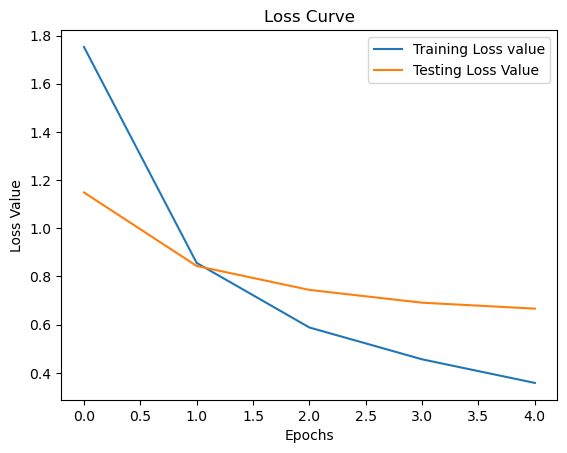

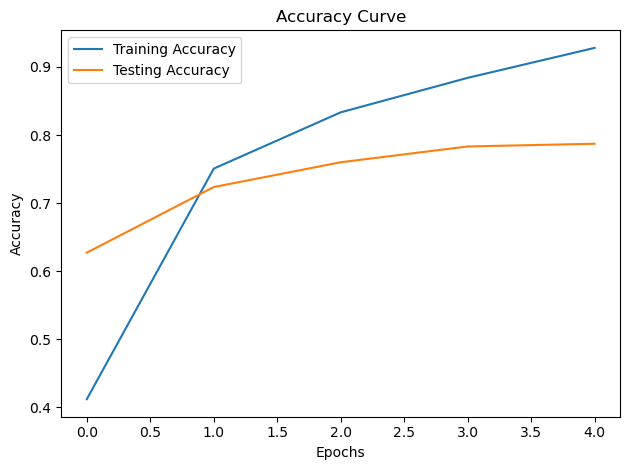

In [13]:
plot_loss_curve(resnet_history)

### Creating and testing EfficientNetBo from tensorflow hub

In [14]:
#creating an uncompiled model
efficientnet_model = create_model(model_url= effiecient_url, 
                                  num_classes= train_data_10_percent.num_classes)

In [15]:
#getting the summary of the model
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [16]:
# Compiling the model
efficientnet_model.compile(loss= tf.keras.losses.CategoricalCrossentropy(),
                           optimizer= tf.keras.optimizers.Adam(),
                           metrics= ['accuracy'])

In [17]:
# Fitting the model
history_efficient = efficientnet_model.fit(train_data_10_percent,
                       epochs= 5,
                       steps_per_epoch= len(train_data_10_percent),
                       callbacks= [create_tensorbaord_callback(
                           dir_name= "tensorflow_hub",
                           experiment_name= 'efficientB0V1'
                       )],
                       validation_data= test_data,
                       validation_steps= len(test_data))

Saving tensorboard log files to: tensorflow_hub/efficientB0V1/20240209-171332
Epoch 1/5
24/24 [==============================] - 38s 1s/step - loss: 1.8009 - accuracy: 0.4787 - val_loss: 1.3014 - val_accuracy: 0.7312
Epoch 2/5
24/24 [==============================] - 32s 1s/step - loss: 1.0376 - accuracy: 0.7920 - val_loss: 0.8658 - val_accuracy: 0.8176
Epoch 3/5
24/24 [==============================] - 32s 1s/step - loss: 0.7295 - accuracy: 0.8440 - val_loss: 0.7003 - val_accuracy: 0.8356
Epoch 4/5
24/24 [==============================] - 31s 1s/step - loss: 0.5843 - accuracy: 0.8720 - val_loss: 0.6108 - val_accuracy: 0.8464
Epoch 5/5
24/24 [==============================] - 32s 1s/step - loss: 0.4974 - accuracy: 0.8920 - val_loss: 0.5587 - val_accuracy: 0.8584


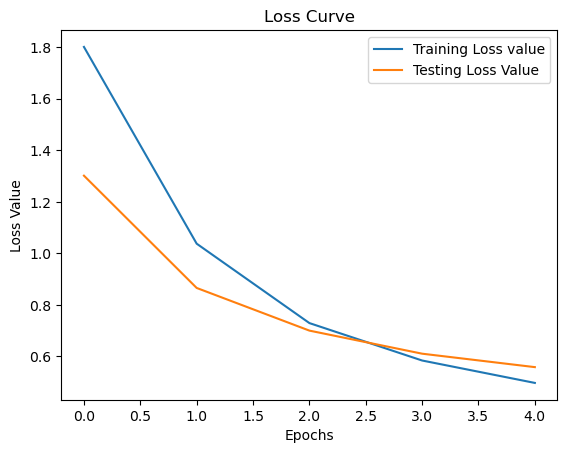

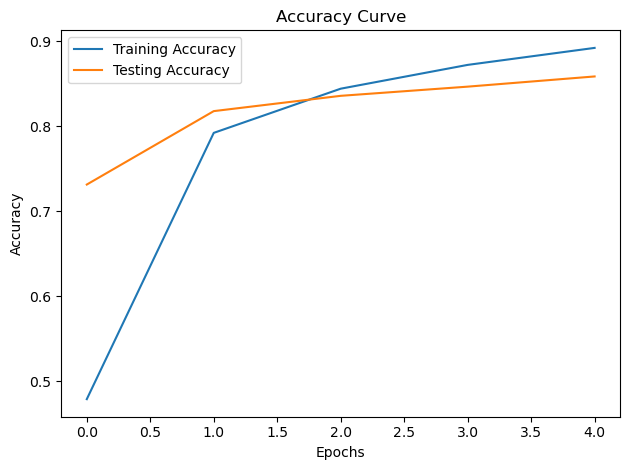

In [18]:
plot_loss_curve(history_efficient)

## Different types of transfer learning

* "As is" transfer learning: using existing model with no changes
* "Feature extraction" transfer learning: using prelearned patterns of an existing model and adjust the output layer of your own problems
* "Fine-tuning" transfer learning: use the prelearned patterns of an existing model and fine-tune many or all of the underlying layers including the new output layers

## Comparing our models results using TensorBoard

> **Note**: When uploading things to TensorBoard.dev, your experiments are public. So if you're running private experiments then do not upload them to TensorBoard.dev

# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/